To make sure you have all installs done, follow : 

```bash
conda create -n shapeDTW
conda activate shapeDTW
pip install -e ".[all]"
```

**The notebook below uses the most high-level methods of our pyshapeDTW package. Feel free to read the README.md and browse our package for more details !**

In [2]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

from pyshapeDTW.descriptors.base import BaseDescriptor
from pyshapeDTW.descriptors.paa import PAA, PAAParams
from pyshapeDTW.descriptors.slope import Slope, SlopeParams
from pyshapeDTW.descriptors.wavelets import DWT, DWTParams
from pyshapeDTW.evaluation.alignment import (
    AlignmentEvalConfig,
    AlignmentEvaluator,
)
from pyshapeDTW.evaluation.classification import (
    ClassificationEvalConfig,
    ClassificationEvaluator,
)
from pyshapeDTW.evaluation.plots import (
    plot_alignment_eval,
    plot_all_alignments,
    plot_classification_comparison,
)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/Users/simondubail/miniconda3/envs/test/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Alignment

A small, 2 minutes computation long, alignment experiment demonstration : 

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluating GunPoint
Loading dataset...
Done loading.


Processing GunPoint: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s]
/Users/simondubail/Documents/MVA/Time Series/pyShapeDTW/pyshapeDTW/evaluation/alignment.py:420: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_results = pd.concat(
Processing datasets:  33%|███▎      | 1/3 [00:23<00:46, 23.12s/it]


Evaluating ECG200
Loading dataset...
Done loading.


Processing datasets:  67%|██████▋   | 2/3 [00:51<00:26, 26.40s/it]


Evaluating Coffee
Loading dataset...
Done loading.


Processing datasets: 100%|██████████| 3/3 [01:15<00:00, 25.14s/it]
/var/folders/ds/cdg70nwj2yq82gl6_211n5wm0000gn/T/ipykernel_81305/3362337487.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/ds/cdg70nwj2yq82gl6_211n5wm0000gn/T/ipykernel_81305/3362337487.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



Results saved to: demo/results/alignment_samples_MAD

Best alignment gaps per dataset:
GunPoint: 26.8800 (stretch=0.40, descriptor=Slope)
Coffee: 16.2098 (stretch=0.50, descriptor=Slope)
ECG200: 13.5208 (stretch=0.50, descriptor=Slope)


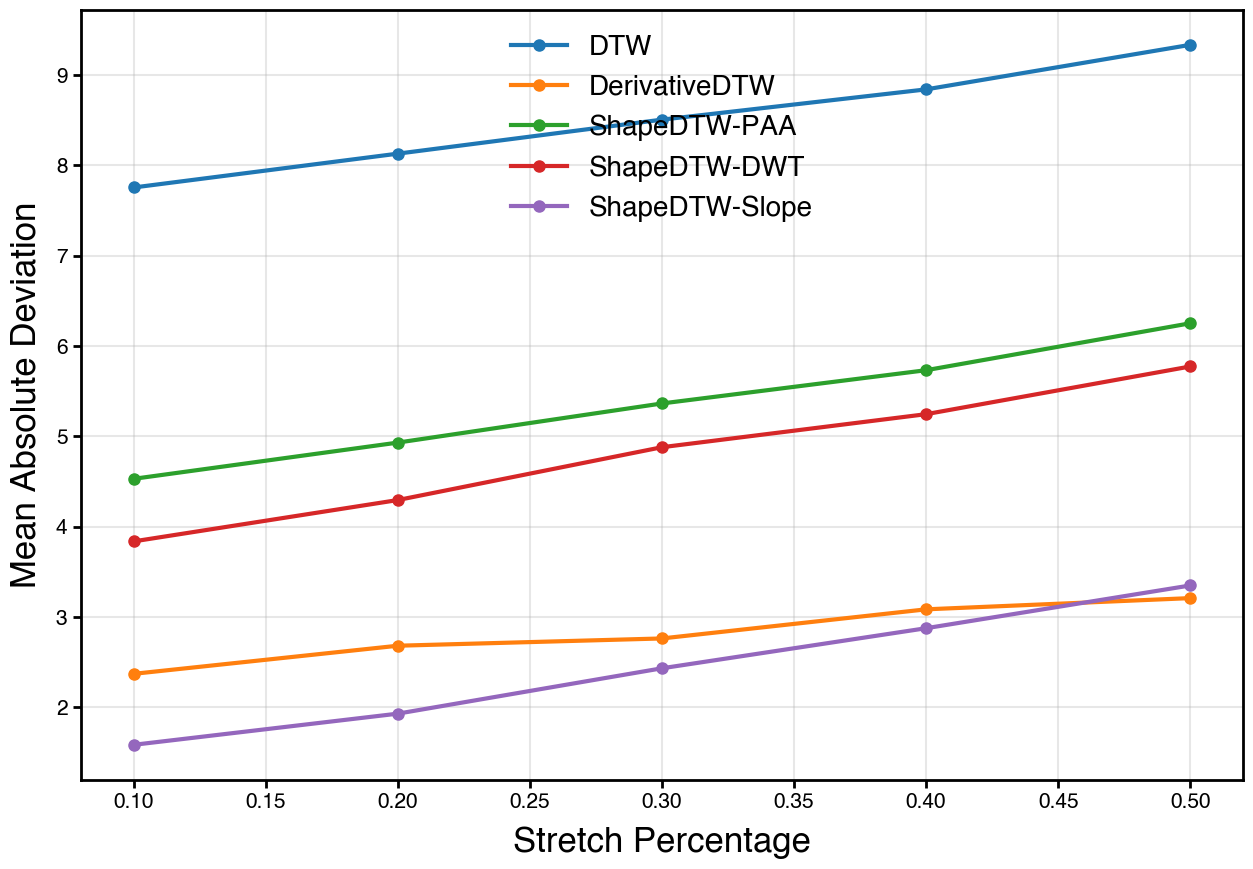

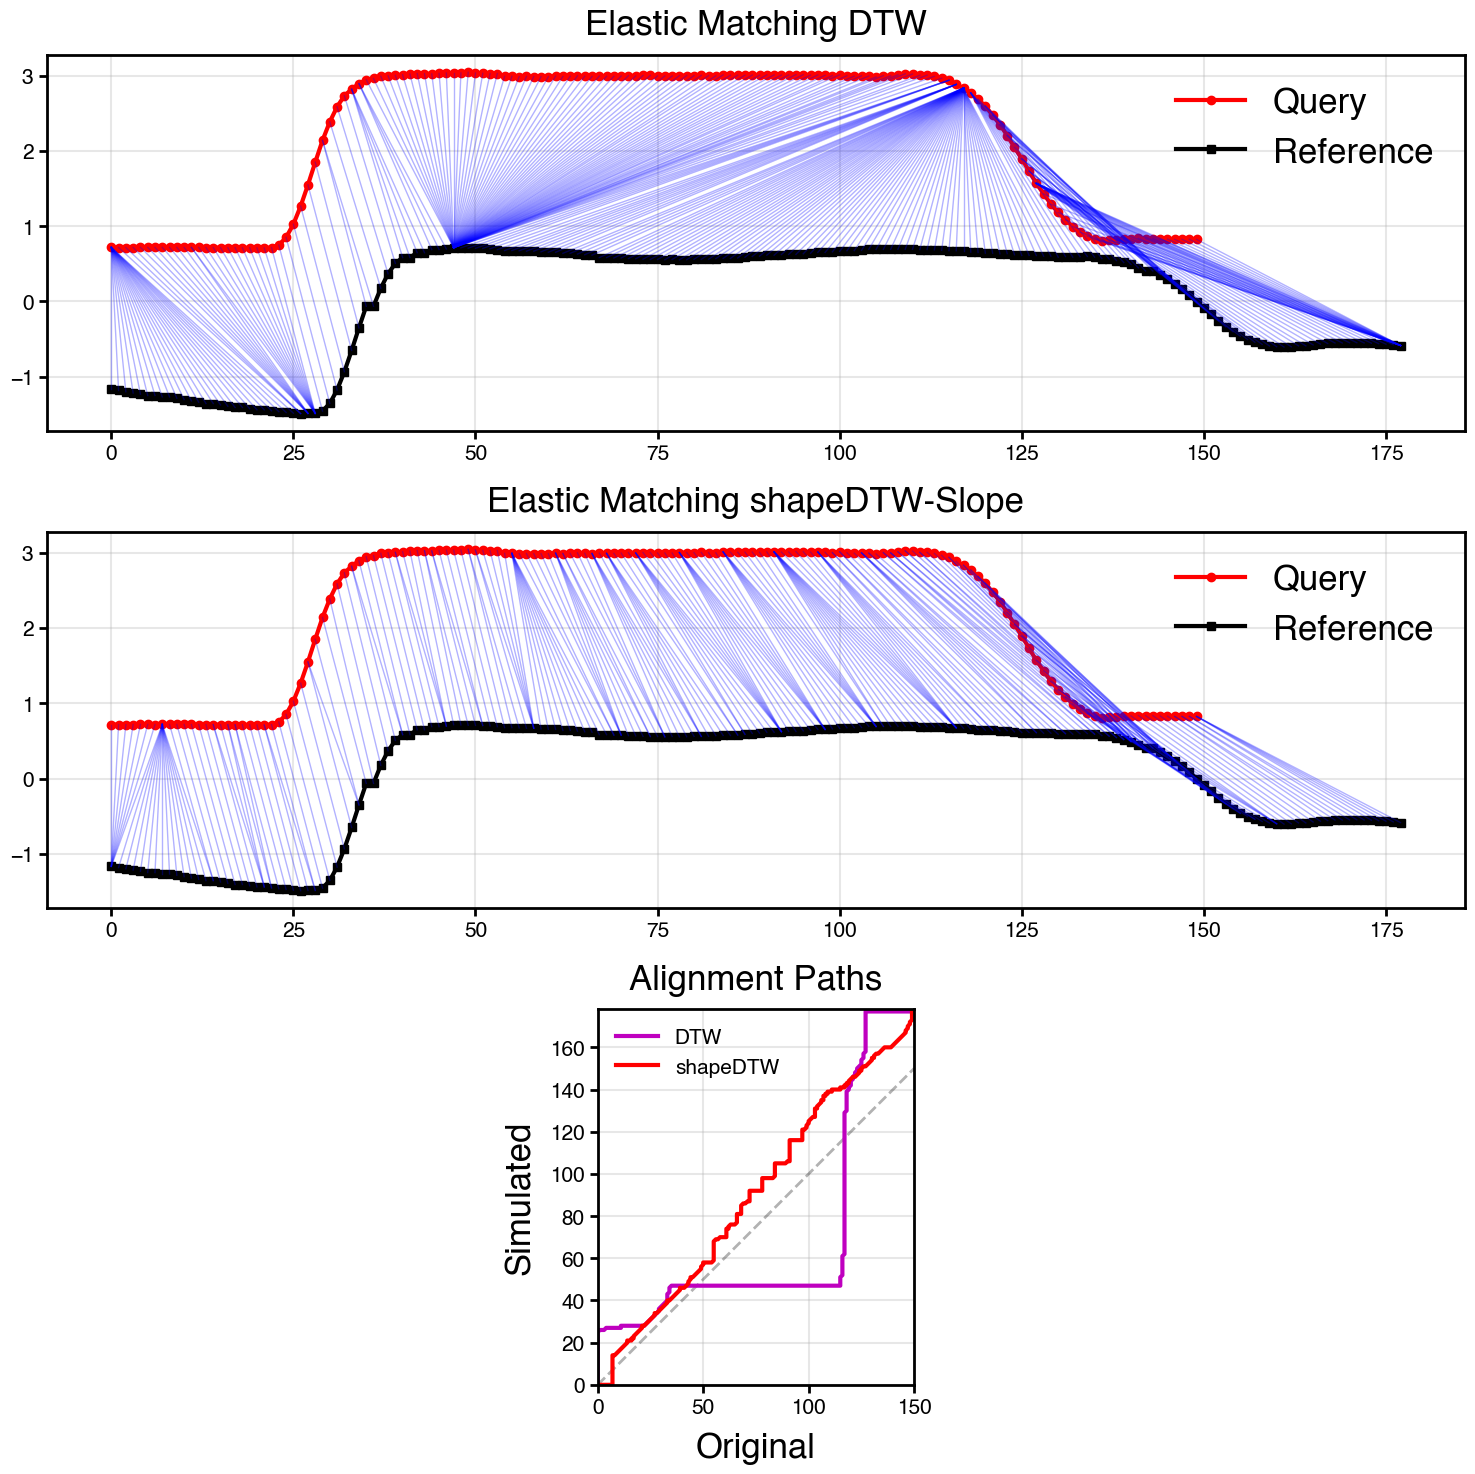

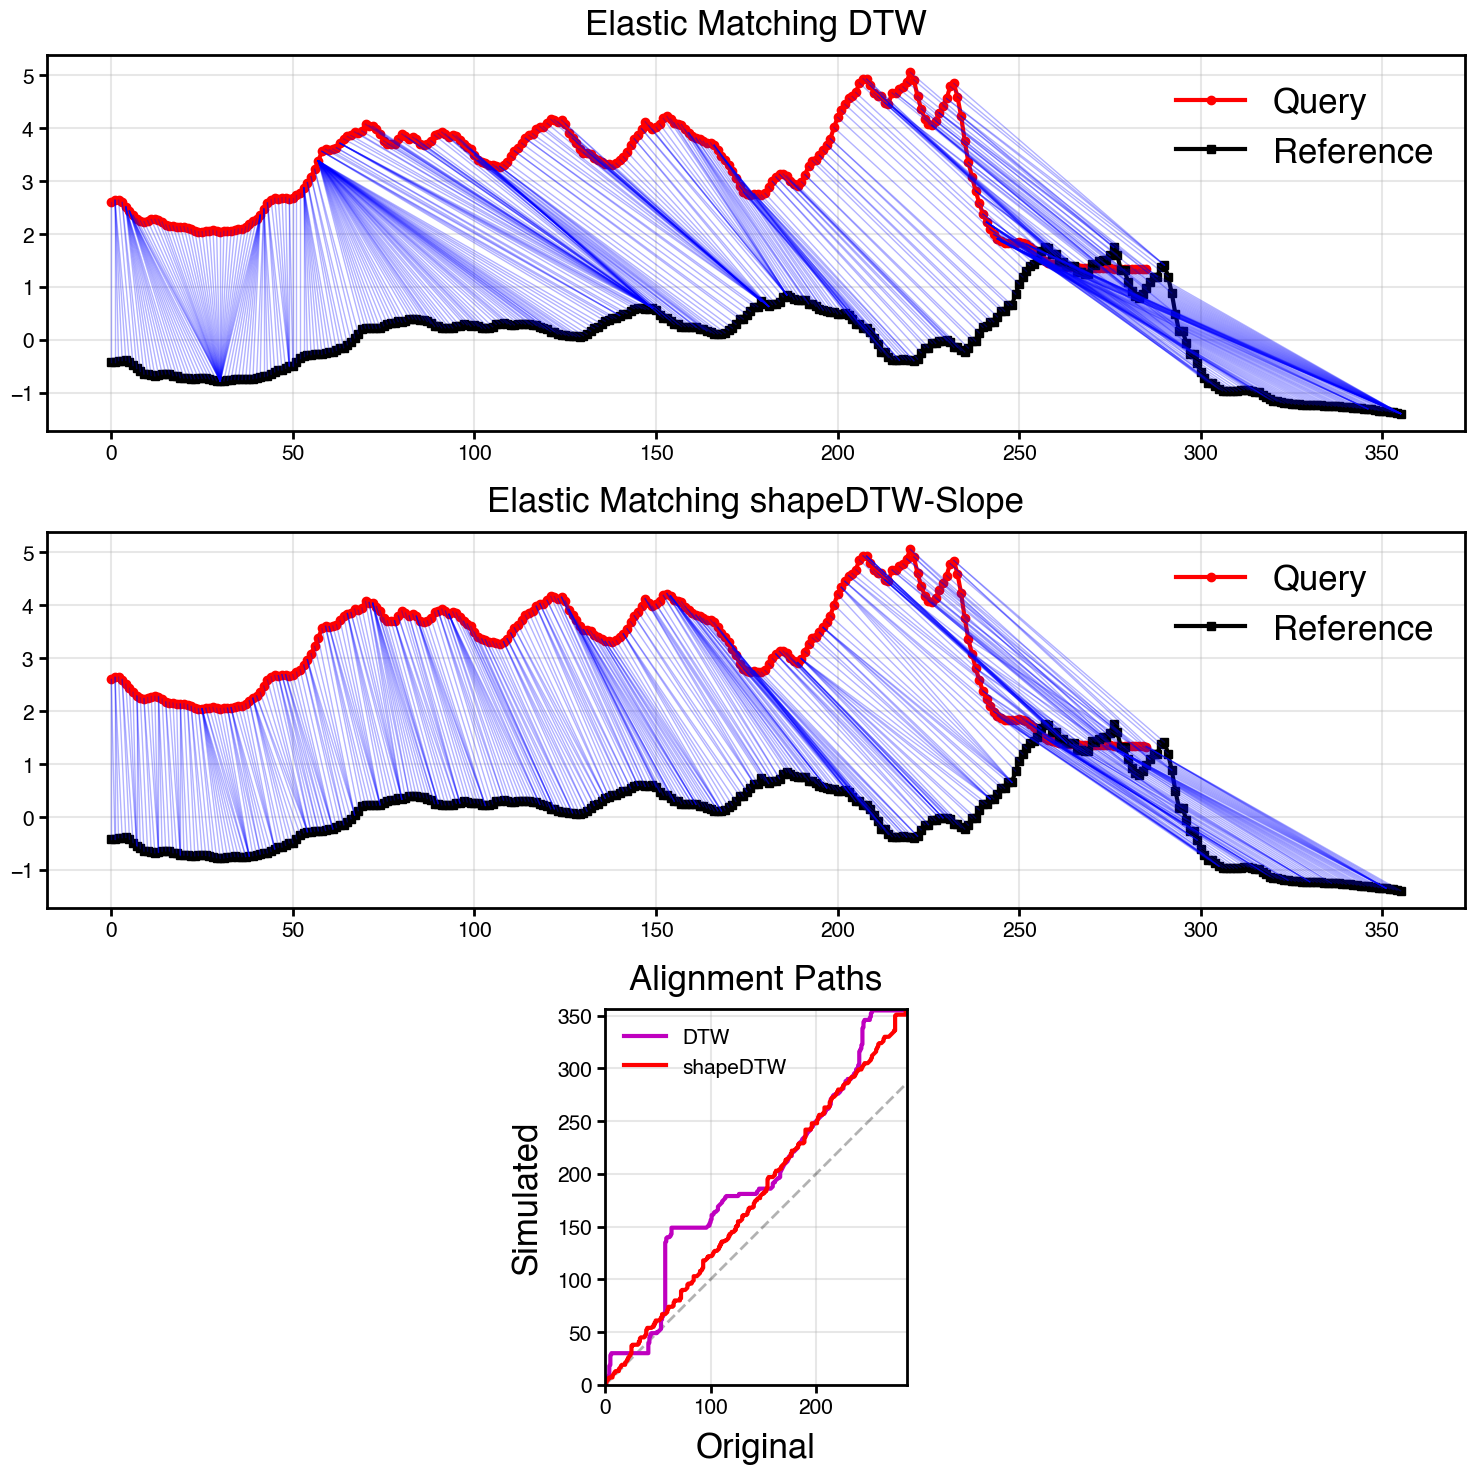

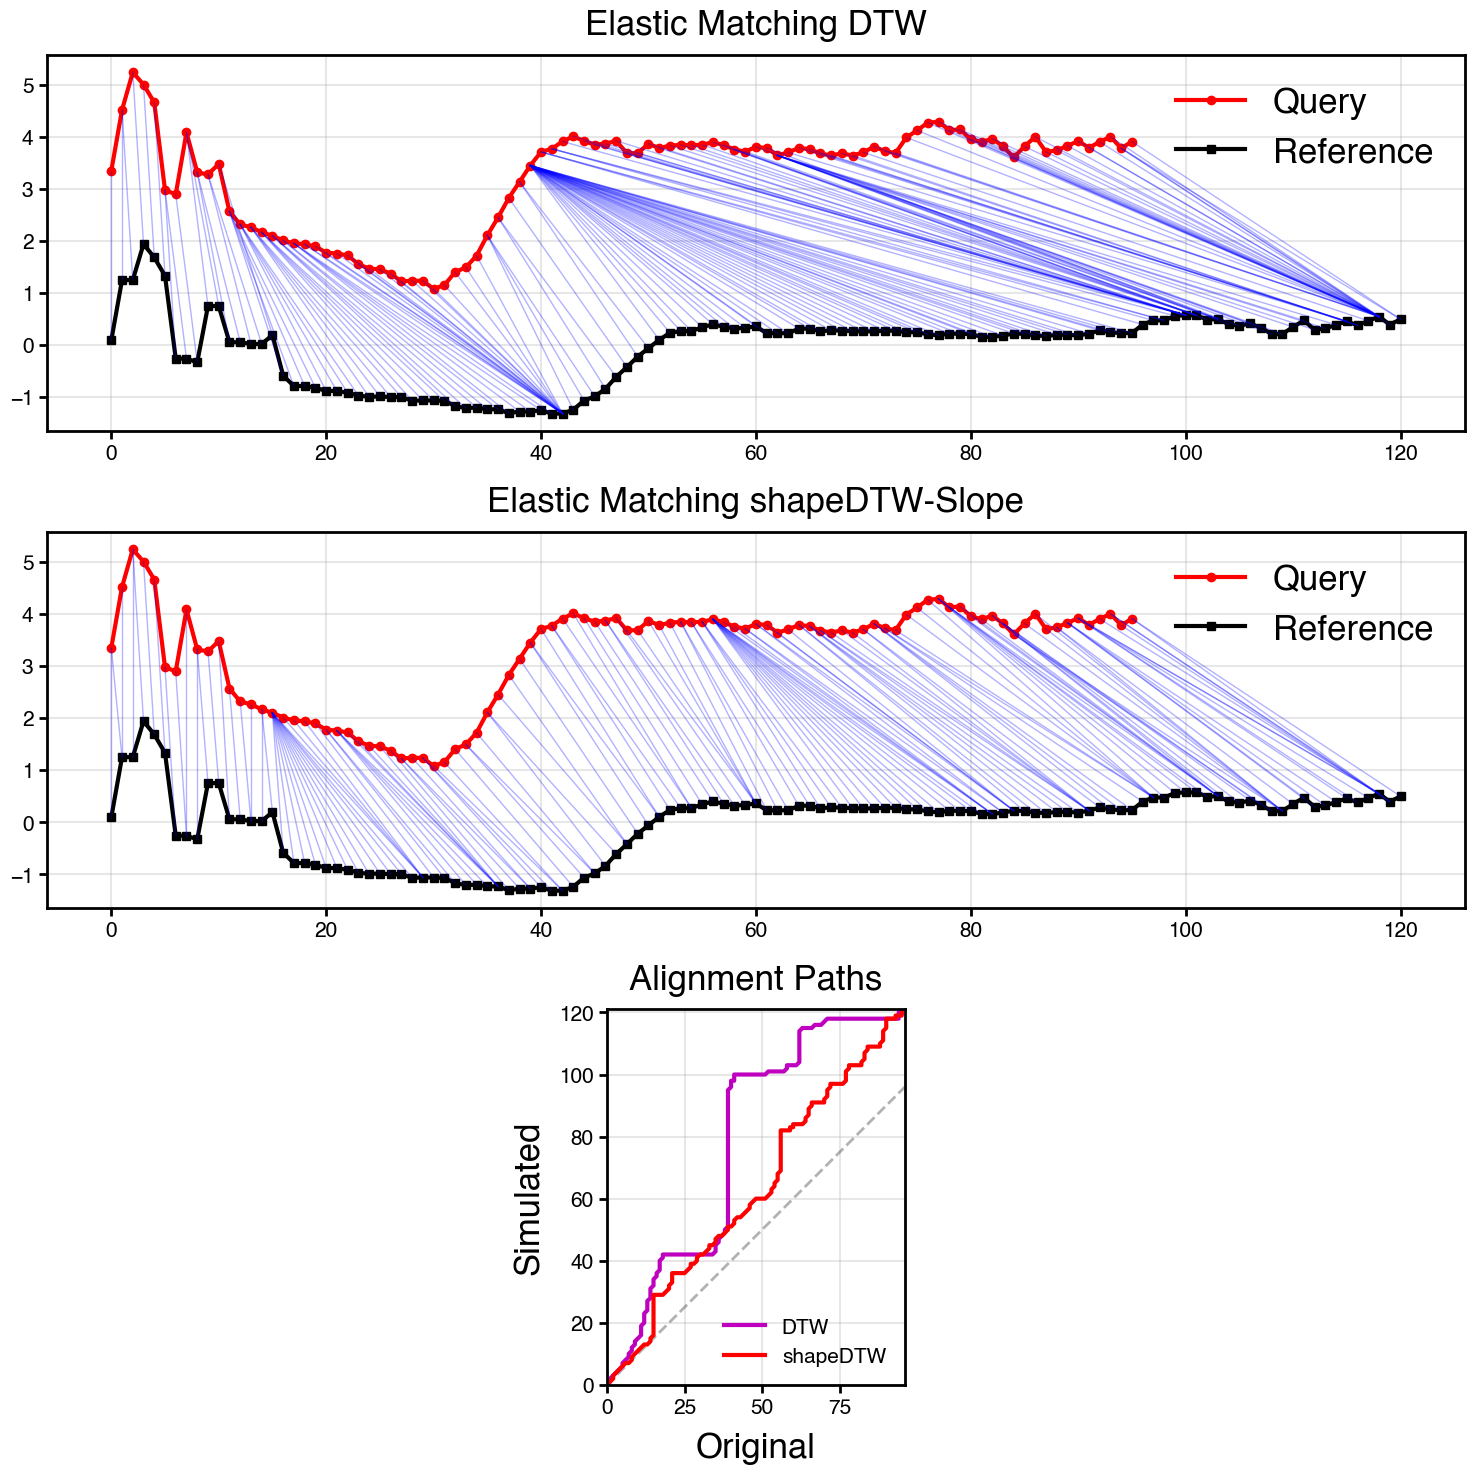

In [3]:
"""Compare DTW and ShapeDTW alignments on UCR datasets."""

### Set up ###
results_dir = Path("demo/results")
stretch_min = 0.1  # "Minimum stretch percentage"
stretch_max = 0.5  # "Maximum stretch percentage"
stretch_steps = 5  # "Number of stretch percentage steps"
stretch_amt = 2  # "Maximum stretch amount"
scale_min = 0.4  # "Minimum scaling factor"
scale_max = 1.0  # "Maximum scaling factor"

dataset_names = ["GunPoint", "ECG200", "Coffee"]

# Create stretch percentages list
stretch_percentages = np.linspace(stretch_min, stretch_max, stretch_steps).tolist()

# Create results directory if it doesn't exist
results_dir = Path(results_dir)
results_dir.mkdir(parents=True, exist_ok=True)


# ------------------------------------------
### Code using our package ###
descriptors: dict[str, BaseDescriptor] = {
    "PAA": PAA(PAAParams(seg_num=5)),  # 5 equal-length intervals
    "DWT": DWT(DWTParams()),  # Default params as in paper
    "Slope": Slope(SlopeParams()),
}

config = AlignmentEvalConfig(
    dataset_names=dataset_names,
    stretch_percentages=stretch_percentages,
    stretch_amount=stretch_amt,
    scale_range=(scale_min, scale_max),
    results_dir=results_dir,
    descriptors=descriptors,
)

# Run evaluation
evaluator = AlignmentEvaluator(config)
results_df, best_alignments = evaluator.run_evaluation()  # one liner

# Save numerical results
results_df.to_csv(results_dir / "alignment_results_full_MAD.csv", index=False)


# ------------------------------------------
### Plotting and al.###
# Save best alignment samples using pickle
with open(results_dir / "best_alignments_full_MAD.pkl", "wb") as f:
    pickle.dump(best_alignments, f)

# Create summary of best alignments
summary_rows = [
    {
        "dataset": sample.dataset,
        "error_gap": sample.error_gap,
        "stretch_pct": sample.stretch_pct,
        "descriptor": sample.descriptor_name,
        "orig_len": len(sample.original),
        "transform_len": len(sample.transformed),
    }
    for sample in best_alignments
]

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(results_dir / "best_alignments_summary_full_MAD.csv", index=False)

# Plot overall results
fig = plot_alignment_eval(results_df)
fig.show()
fig.savefig(results_dir / "alignment_results_full_MAD.png")

# Create alignment_samples subfolder if it doesn't exist
samples_dir = results_dir / "alignment_samples_MAD"
samples_dir.mkdir(exist_ok=True)

# Get indices of top 5 error gaps
top_5_indices = summary_df.sort_values("error_gap", ascending=False).index[:5]

# Plot the 5 alignments with largest error gaps
for i, idx in enumerate(top_5_indices):
    alignment = best_alignments[idx]

    # Create matches dictionary for each method
    matches = {
        # "GT": alignment.gt_match,
        "DTW": alignment.dtw_match,
    }
    if alignment.shapedtw_match is not None:
        matches[f"shapeDTW-{alignment.descriptor_name}"] = alignment.shapedtw_match

    # Create combined plot
    fig = plot_all_alignments(
        alignment.original, alignment.transformed, matches, figsize=(15, 15)
    )

    # Save plot with error gap info in filename
    error_gap = summary_df.loc[idx, "error_gap"]
    fig.show()
    fig.savefig(samples_dir / f"alignment_sample_{i+1}_gap_{error_gap:.4f}.png")

# Print summary
print(f"\nResults saved to: {samples_dir}")
print("\nBest alignment gaps per dataset:")
for _, row in summary_df.sort_values("error_gap", ascending=False).iterrows():
    print(
        f"{row['dataset']}: {row['error_gap']:.4f} "
        f"(stretch={row['stretch_pct']:.2f}, descriptor={row['descriptor']})"
    )

**Note : interestingly enough, by cutting down to just GunPoint, Coffee and ECG200 datasets for demonstration purposes, dDTW performs better than shapeDTW-PAA and shapeDTW-DWT. This effect disappears on larger scale studies like the one in the paper. Still, classic DTW performs badly compared to other methods.**

# Classification

A small, 2 minutes computation long, classification experiment demonstration : 

Processing datasets:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating GunPoint

Loading dataset...
Done loading.
Method : simple DTW ...


Computing DTW distances: 100%|██████████| 150/150 [00:05<00:00, 27.13it/s]
/Users/simondubail/Documents/MVA/Time Series/pyShapeDTW/pyshapeDTW/evaluation/classification.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat(




Method: ShapeDTW-PAA ...


Computing DTW distances: 100%|██████████| 150/150 [00:06<00:00, 23.86it/s]




Method: ShapeDTW-DWT ...


Computing DTW distances: 100%|██████████| 150/150 [00:07<00:00, 18.93it/s]




Method: ShapeDTW-Slope ...


Processing datasets:  33%|███▎      | 1/3 [00:33<01:07, 33.58s/it]



Evaluating ECG200

Loading dataset...
Done loading.
Method : simple DTW ...


Computing DTW distances: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]




Method: ShapeDTW-PAA ...


Computing DTW distances: 100%|██████████| 100/100 [00:03<00:00, 26.04it/s]




Method: ShapeDTW-DWT ...


Computing DTW distances: 100%|██████████| 100/100 [00:04<00:00, 20.60it/s]




Method: ShapeDTW-Slope ...


Processing datasets:  67%|██████▋   | 2/3 [00:54<00:26, 26.32s/it]



Evaluating Coffee

Loading dataset...
Done loading.
Method : simple DTW ...


Computing DTW distances: 100%|██████████| 28/28 [00:01<00:00, 15.84it/s]




Method: ShapeDTW-PAA ...


Computing DTW distances: 100%|██████████| 28/28 [00:01<00:00, 15.18it/s]




Method: ShapeDTW-DWT ...


Computing DTW distances: 100%|██████████| 28/28 [00:02<00:00, 11.33it/s]




Method: ShapeDTW-Slope ...


Processing datasets: 100%|██████████| 3/3 [01:06<00:00, 22.26s/it]
/Users/simondubail/Documents/MVA/Time Series/pyShapeDTW/pyshapeDTW/evaluation/plots.py:262: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=35, frameon=False)
/Users/simondubail/Documents/MVA/Time Series/pyShapeDTW/pyshapeDTW/evaluation/plots.py:262: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=35, frameon=False)
/Users/simondubail/Documents/MVA/Time Series/pyShapeDTW/pyshapeDTW/evaluation/plots.py:262: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=35, frameon=False)


/var/folders/ds/cdg70nwj2yq82gl6_211n5wm0000gn/T/ipykernel_81305/3713227579.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


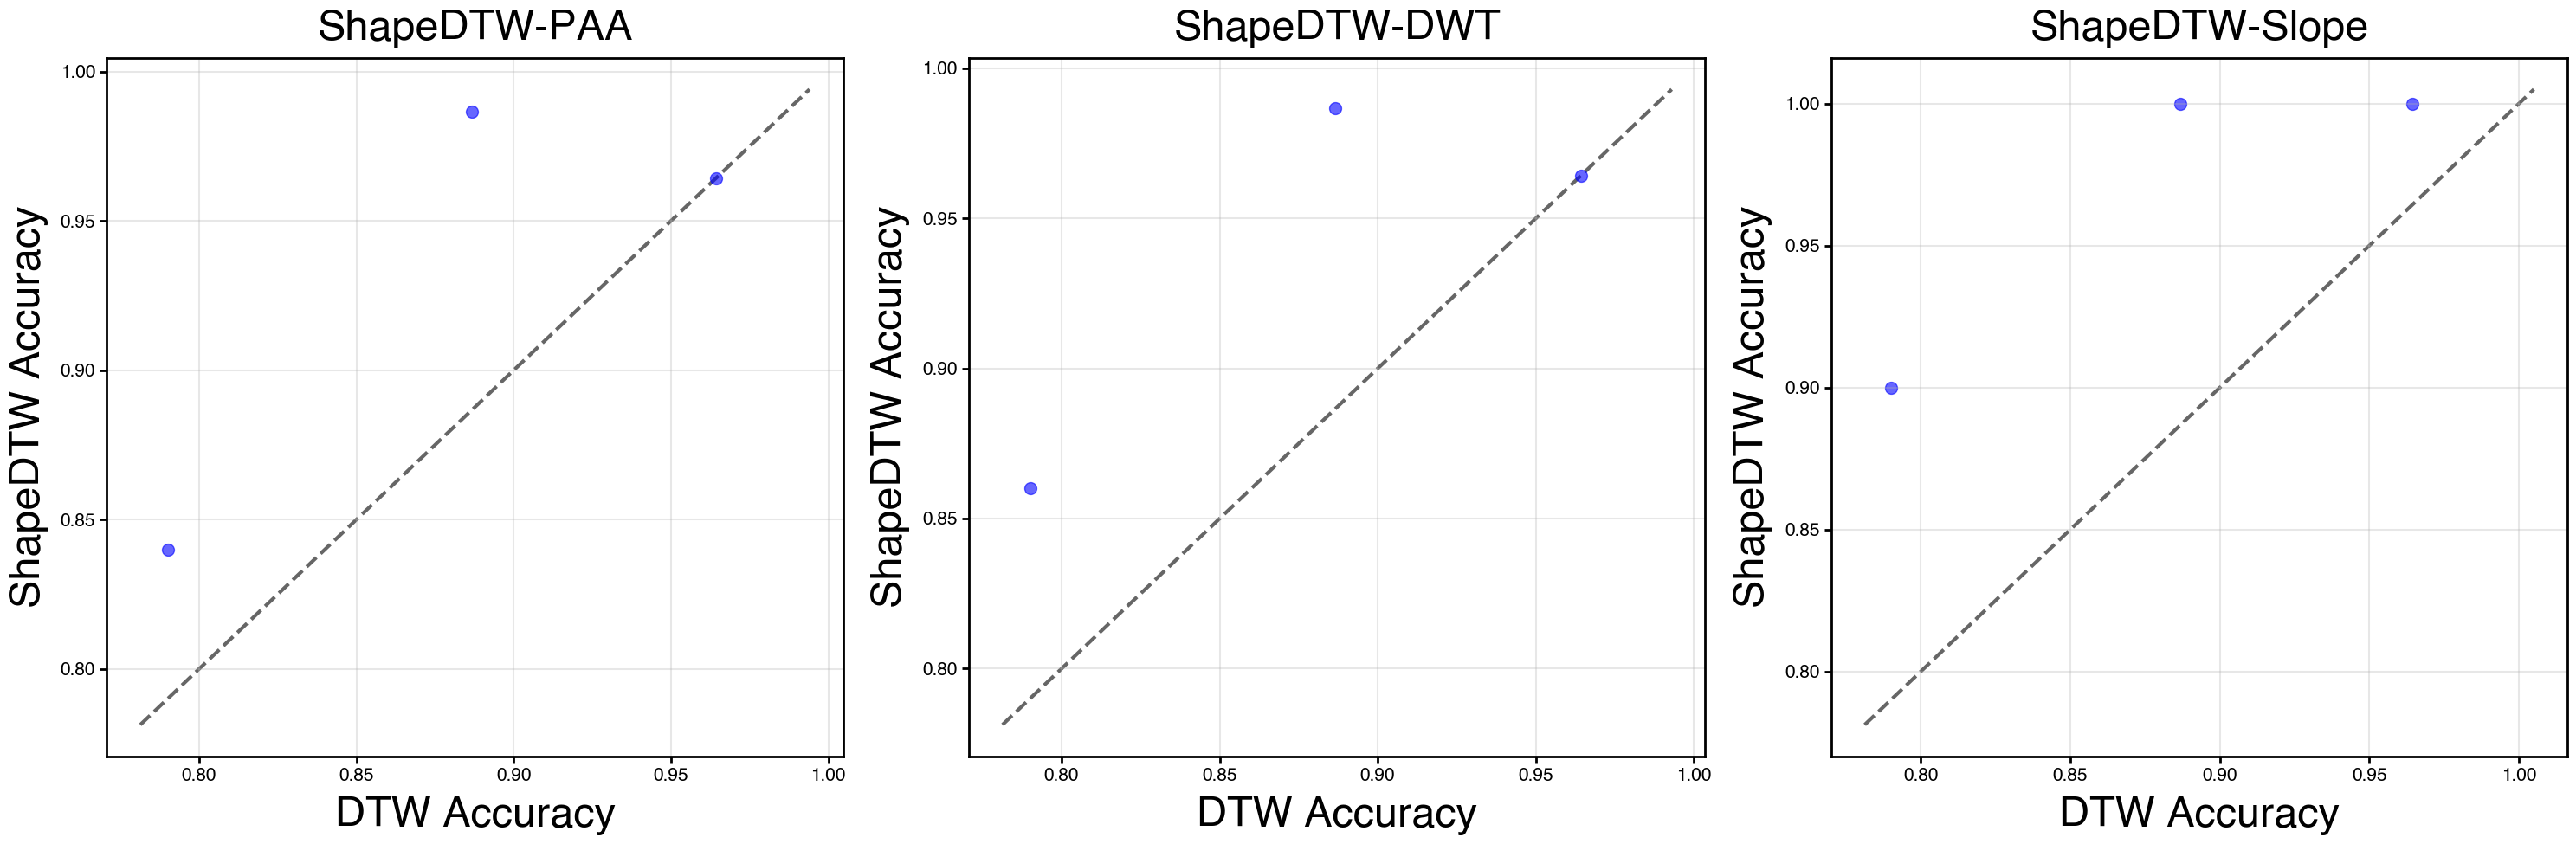

In [4]:
"""Run classification evaluation on UCR datasets comparing DTW and shapeDTW."""

dataset_names = ["GunPoint", "ECG200", "Coffee"]  # Example datasets

# ------------------------------------------
### Code using our package ###

# Setup descriptors with parameters from paper
descriptors: dict[str, BaseDescriptor] = {
    "PAA": PAA(PAAParams(seg_num=5)),  # 5 equal-length intervals
    "DWT": DWT(DWTParams()),  # Default params as in paper
    "Slope": Slope(SlopeParams()),
}

# Configure evaluation
config = ClassificationEvalConfig(
    dataset_names=dataset_names,
    descriptors=descriptors,
    seqlen=30,  # As specified in paper
    results_dir=Path("demo/results"),
)

# Run evaluation
evaluator = ClassificationEvaluator(config)
results_df = evaluator.run_evaluation(
    path=config.results_dir / "classification_results_full_incremental.csv"
)

# ------------------------------------------
# Plot results
fig = plot_classification_comparison(results_df)

results_df.to_csv(config.results_dir / "classification_results_full.csv", index=False)
fig.savefig(config.results_dir / "classification_comparison_full.png")
fig.show()